In [1]:
import pandas as pd
from pathlib import Path
import os
BASE_DIR = Path().resolve()
# df = pd.read_csv(os.path.join(BASE_DIR, "data", "prices.csv"))
df = pd.read_csv(os.path.join(BASE_DIR, "data", "prices_with_generation.csv"))
df['timestamp']=pd.to_datetime(df['timestamp'])
df.head()

,timestamp,energy_price,time_block,generation
0,2024-01-01 01:00:00,0.10,4.0,0.0
1,2024-01-01 02:00:00,0.01,4.0,0.0
2,2024-01-01 03:00:00,0.03,4.0,0.0
3,2024-01-01 04:00:00,0.00,4.0,0.0
4,2024-01-01 05:00:00,0.00,4.0,0.0


In [2]:
import pandas as pd
from pulp import (
    LpProblem, LpMinimize, LpVariable, lpSum,
    PULP_CBC_CMD, LpStatus, value
)


def optimize(
    prices: pd.DataFrame,
    battery_capacity: int,
    c_rate: float,
    min_soc: int,
    max_soc: int,
) -> pd.DataFrame:
    """
    Battery arbitrage optimization using linear programming.
    """

    # --------------------
    # Preprocessing
    # --------------------
    df = prices.copy()
    df = df.sort_values(by="timestamp", ascending=True)
    df["hour"] = df["timestamp"].dt.hour
    df = df.set_index("timestamp", drop=False)

    battery_power = battery_capacity * c_rate
    min_soc_abs = min_soc * battery_capacity / 100
    max_soc_abs = max_soc * battery_capacity / 100
    average_price = df["energy_price"].mean()

    discharge_upper_bound = battery_power
    charge_upper_bound = battery_power

    # --------------------
    # Problem definition
    # --------------------
    prob = LpProblem("Peaks", LpMinimize)

    # --------------------
    # Variables
    # --------------------

    # Battery charge/discharge in interval t (+ charge, − discharge)
    x = {
        t: LpVariable(
            f"x_{t}",
            lowBound=-charge_upper_bound,
            upBound=discharge_upper_bound,
            cat="Continuous",
        )
        for t in df.index
    }

    # State of charge at beginning of interval t
    y = {
        t: LpVariable(
            f"y_{t}",
            lowBound=min_soc_abs,
            upBound=max_soc_abs,
            cat="Continuous",
        )
        for t in df.index
    }
    #auxiliary variable for set 4 of constraints
    b = {
        t: LpVariable(f"b_{t}", cat="Binary")
        for t in df.index
    }

    # --------------------
    # Objective function
    # --------------------
    prob += lpSum(
        x[t] * df.loc[t, "energy_price"] / 1000
        for t in df.index
    ), "minimize_energy_cost"

    # --------------------
    # Constraints
    # --------------------
    idx = list(df.index)
    first_index = idx[0]

    # Initial SOC (start full)
    prob += y[first_index] == max_soc_abs, "initial_SOC"

    # SOC balance
    for i in range(1, len(idx)):
        t = idx[i]
        prev_t = idx[i - 1]
        prob += y[t] == y[prev_t] + x[prev_t], f"soc_balance_{t}"

    # Charging / discharging limits based on SOC
    for i in range(1, len(idx)):
        t = idx[i]
        prob += x[t] >= -(y[t] - min_soc_abs), f"discharge_limit_{i}"
        prob += x[t] <= (max_soc_abs - y[t]), f"charge_limit_{i}"
        
    ### 2nd SET OF CONSTRAINTS
    # The battery must not charge between 4:00 and 6:00.
    # Formulation: for all hours {4,5,6} x<=0

    no_charge_hours = [5, 6]
    for t in df.index:
        if t.hour in no_charge_hours:
            prob += x[t] <= 0, f"NoCharge_{t}"

    ## 3nd SET OF CONSTRAINTS
    # The SOC at 8h must be at least 50%

    soc_8am = 0.5*battery_capacity
    for t in df.index:
        if t.hour==8:
            prob += y[t] >=soc_8am, f"SOC_at_8AM_min{t}"


    ## 4th SET OF CONSTRAINTS
    #PV production###
    for t in df.index:
        prob += x[t] <= df.loc[t, 'generation'], f"generation_limit_{t}"


    ## 5th SET OF CONSTRAINTS
    # Discharging is allowed only if the current price is above the average price
    # add binary variable b_i

    M_1 = charge_upper_bound
    for t in df.index:
        # If b[t] = 0 → x[t] ≥ 0  (not discharging)
        # If b[t] = 1 → x[t] can be ≤ 0 (discharging)
        prob += x[t] >= -M_1 * b[t], f"discharge_indicator_{t}"
        # If b[t] = 1 → x[t] must be ≤ 0 (discharging)
        prob += x[t] <= (1 - b[t]) * M_1, f"discharge_indicator_b_{t}"


    M_2 = df['energy_price'].max()
    for t in df.index:
        prob += df.loc[t, 'energy_price'] - average_price <= M_2 * b[t], f"price_upper_{t}"
        prob += df.loc[t, 'energy_price'] - average_price >= - M_2 * (1 - b[t]), f"price_lower_{t}"

    # --------------------
    # Solve
    # --------------------
    prob.writeLP("ilp-model.lp")
    prob.solve(PULP_CBC_CMD(msg=False, timeLimit=120))

    print("Solver Status:", LpStatus[prob.status])
    print("Objective value:", round(value(prob.objective), 2))

    # --------------------
    # Results
    # --------------------
    res = pd.DataFrame({
        "timestamp": df["timestamp"],
        "price": df["energy_price"],
        "battery(x)": [x[t].varValue for t in df.index],
        "soc": [y[t].varValue for t in df.index],
    })

    res["charging"] = res["battery(x)"].clip(lower=0)
    res["discharging"] = -res["battery(x)"].clip(upper=0)
    res["cost"] = res["price"] * res["battery(x)"] / 1000

    return res

BATTERY_CAPACITY= 250
C_RATE=0.5
MIN_SOC=10
MAX_SOC=90

result = optimize(df, battery_capacity=BATTERY_CAPACITY, c_rate=C_RATE, min_soc=MIN_SOC, max_soc=MAX_SOC)
result.head()

Solver Status: Optimal
Objective value: -4811.06


,timestamp,price,battery(x),soc,charging,discharging,cost
timestamp,,,,,,,
2024-01-01 01:00:00,2024-01-01 01:00:00,0.10,0.0,225.0,0.0,-0.0,0.0
2024-01-01 02:00:00,2024-01-01 02:00:00,0.01,0.0,225.0,0.0,-0.0,0.0
2024-01-01 03:00:00,2024-01-01 03:00:00,0.03,0.0,225.0,0.0,-0.0,0.0
2024-01-01 04:00:00,2024-01-01 04:00:00,0.00,0.0,225.0,0.0,-0.0,0.0
2024-01-01 05:00:00,2024-01-01 05:00:00,0.00,0.0,225.0,0.0,-0.0,0.0


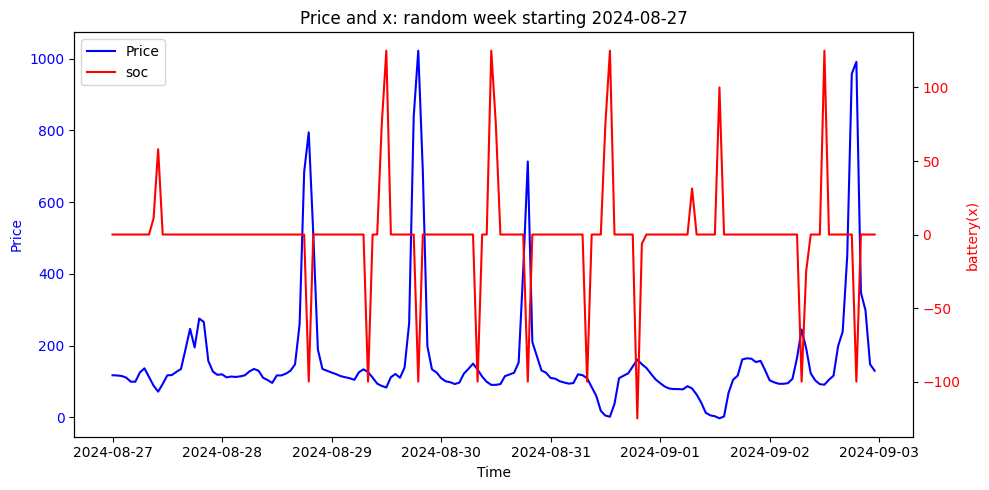

91.28509393145849


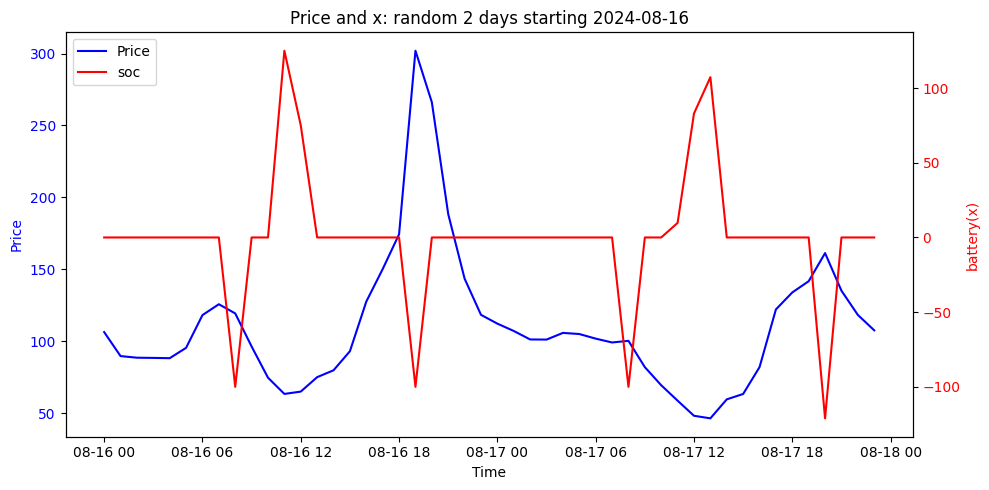

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

result["timestamp"] = pd.to_datetime(result["timestamp"])

# Filter for August
august = result[result["timestamp"].dt.month == 8]

# Pick a random start date (within available range)
start_date = np.random.choice(august["timestamp"].dt.date.unique())
start_date = pd.Timestamp(start_date)
end_date = start_date + pd.Timedelta(days=7)

# Slice the week
week = result[(result["timestamp"] >= start_date) & (result["timestamp"] < end_date)]
week = week.set_index("timestamp")

# Plot
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(week.index, week["price"], color="blue", label="Price")
ax1.set_ylabel("Price", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_xlabel("Time")

ax2 = ax1.twinx()
ax2.plot(week.index, week["battery(x)"], color="red", label="soc")
ax2.set_ylabel("battery(x)", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

plt.title(f"Price and x: random week starting {start_date.date()}")
plt.tight_layout()
plt.show()

### RANDOM DAY - repeated code
start_date = np.random.choice(august["timestamp"].dt.date.unique())
start_date = pd.Timestamp(start_date)
end_date = start_date + pd.Timedelta(days=2)

# Slice the week
week = result[(result["timestamp"] >= start_date) & (result["timestamp"] < end_date)]
week = week.set_index("timestamp")

# Plot
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(week.index, week["price"], color="blue", label="Price")
ax1.set_ylabel("Price", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_xlabel("Time")

ax2 = ax1.twinx()
ax2.plot(week.index, week["battery(x)"], color="red", label="soc")
ax2.set_ylabel("battery(x)", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# A = result['price'].mean()
# print(A)
# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

plt.title(f"Price and x: random 2 days starting {start_date.date()}")
plt.tight_layout()
plt.show()
